## Image Embeddings

### Preface

**Summary**
- TBD

**Acknowledgements**
- Dataset: https://www.tensorflow.org/datasets/catalog/tf_flowers
- Blog Article: https://rom1504.medium.com/image-embeddings-ed1b194d113e
- Code Repo: https://github.com/rom1504/image_embeddings
- Code File: https://github.com/rom1504/image_embeddings/blob/master/notebooks/from_scratch.ipynb

### Initialization: Download and Save

**Packages**

In [27]:
import numpy as pkg_num
import os as pkg_os
import time as pkg_time
import math as pkg_math
import warnings as pkg_warnings
import matplotlib.pyplot as pkg_mplot
import matplotlib.image as pkg_mp_image
import pathlib as pkg_pathlib
import shutil as pkg_shutil

In [28]:
# Record Start Time
run_start_time = pkg_time.time()

In [29]:
# Miscellaneous
%matplotlib inline

# Tensor Flow is optimized for CUDA-GPU, 
# But we are running on a different GPU or simply CPU, so ignore warnings
pkg_warnings.filterwarnings(action="ignore")

# OpenMP library may be linked and loaded multiple times due to transitive dependencies
# Informed that multiple instances of OpenMP library is OK for us
# That error goes away with following setting
pkg_os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

In [30]:
import pandas as pkg_pandas
import absl.logging as pkg_logging
import IPython.display as pkg_disp
import ipywidgets as pkg_widgets
import PIL as pkg_pil
import PIL.Image as pkg_pil_image
import pyarrow as pkg_arrow
import pyarrow.parquet as pkg_parquet
import tensorflow as pkg_tf
import tensorflow_datasets as pkg_tfds
import tensorflow_datasets.core.dataset_utils as pkg_tfds_utils
import tensorflow_datasets.core.features as pkg_tfds_features
import efficientnet as pkg_effinet
import efficientnet.preprocessing as pkg_effinet_preprocessing
import efficientnet.tfkeras as pkg_tfkeras
from efficientnet.tfkeras import EfficientNetB6 as EfficientNetRef
import faiss as pkg_faiss

**Common**

In [31]:
# Performance related settings
AUTOTUNE = pkg_tf.data.AUTOTUNE

# Image Size (Target)
image_height = 180
image_width = 180
image_size = (image_height, image_width)

# Path stuff
repo_root_dirpath = pkg_pathlib.Path.cwd().parent
temp_root_dirpath = repo_root_dirpath.joinpath(".outputs")
temp_flowers_ds_dirpath = temp_root_dirpath.joinpath(".datasets/tf_flowers")

folder_name_downloads = "downloads"
temp_downloads_dirpath = temp_flowers_ds_dirpath.joinpath(folder_name_downloads)

folder_name_images = "images"
temp_images_dirpath = temp_flowers_ds_dirpath.joinpath(folder_name_images)

folder_name_tfrecords = "tfrecords"
temp_tfrecords_dirpath = temp_flowers_ds_dirpath.joinpath(folder_name_tfrecords)

folder_name_embeddings = "embeddings"
temp_embeddings_dirpath = temp_flowers_ds_dirpath.joinpath(folder_name_embeddings)

temp_dirpaths = {
    folder_name_downloads: temp_downloads_dirpath,
    folder_name_images : temp_images_dirpath,
    folder_name_tfrecords: temp_tfrecords_dirpath,
    folder_name_embeddings : temp_embeddings_dirpath
}

In [32]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

In [33]:
def configure_for_batch_performance(ds,batch_size):
  ds = configure_for_performance(ds)
  ds = ds.batch(batch_size=batch_size)
  return ds

In [34]:
def create_dirpath(dirpath):
    # Create the data directory
    dirpath.mkdir(parents=True, exist_ok=True)
    return dirpath

In [35]:
def recreate_dirpath(dirpath):
    # (Re)create the data directory
    pkg_shutil.rmtree(dirpath, ignore_errors=True)
    dirpath.mkdir(parents=True, exist_ok=False)
    return dirpath

In [36]:
def recreate_folder(folder_name):
    return recreate_dirpath(temp_dirpaths[folder_name])

In [37]:
def print_folder_stats(folder_name):
    checkpoint_time = int(pkg_time.time() - run_start_time)
    print("Directory Stats ({}), at {} seconds: {}".format(\
        folder_name, checkpoint_time, temp_dirpaths[folder_name].stat()))


**Load Data**

In [38]:
def download_dataset(dataset_name, data_dirpath):
    ds, ds_info = pkg_tfds.load(name=dataset_name, data_dir=data_dirpath, 
        split='train', with_info=True)
    return ds, ds_info

def save_examples(ds, ds_info, data_dirpath, num_examples = 10, image_key=None):
  """Save images from an image classification dataset.

  Only works with datasets that have 1 image feature and optionally 1 label
  feature (both inferred from `ds_info`). Note the dataset should be unbatched.

  Usage:

  ```python
  ds, ds_info = tfds.load('cifar10', split='train', with_info=True)
  fig = save_examples(ds, ds_info, data_dir)
  ```

  Args:
    ds: `tf.data.Dataset`. The tf.data.Dataset object to visualize. Examples
      should not be batched.
    num_examples: `int`. Number of examples to save
    ds_info: The dataset info object to which extract the label and features
      info. Available either through `tfds.load('mnist', with_info=True)` or
      `tfds.builder('mnist').info`
    data_dir: `pathlib.Path`. Where to save images
    image_key: `string`, name of the feature that contains the image. If not
       set, the system will try to auto-detect it.

  Returns:
  """

  if not image_key:
    # Infer the image and label keys
    image_keys = [
        k for k, feature in ds_info.features.items()
        if isinstance(feature, pkg_tfds_features.Image)
    ]

    if not image_keys:
      raise ValueError(
          "Visualisation not supported for dataset `{}`. Was not able to "
          "auto-infer image.".format(ds_info.name))

    if len(image_keys) > 1:
      raise ValueError(
          "Multiple image features detected in the dataset. Using the first one. You can "
          "use `image_key` argument to override. Images detected: %s" %
          (",".join(image_keys)))

    image_key = image_keys[0]

  label_keys = [
      k for k, feature in ds_info.features.items()
      if isinstance(feature, pkg_tfds_features.ClassLabel)
  ]

  label_key = label_keys[0] if len(label_keys) == 1 else None
  if not label_key:
    pkg_logging.info("Was not able to auto-infer label.")

  examples = list(pkg_tfds_utils.as_numpy(ds.take(num_examples)))
  
  # Save the images as files on disk
  for i, ex in enumerate(examples):
    if not isinstance(ex, dict):
      raise ValueError(
          "tensorflow_datasets.show_examples requires examples as `dict`, with the same "
          "structure as `ds_info.features`. It is currently not compatible "
          "with `as_supervised=True`. Received: {}".format(type(ex)))

    # Plot the image
    image = ex[image_key]
    if len(image.shape) != 3:
      raise ValueError(
          "Image dimension should be 3. tensorflow_datasets.show_examples does not support "
          "batched examples or video.")
    _, _, c = image.shape
    if c == 1:
      image = image.reshape(image.shape[:2])
    image = pkg_effinet_preprocessing.center_crop_and_resize(image, 224).astype(pkg_num.uint8)
    im = pkg_pil_image.fromarray(image)
    # Plot the label
    if label_key:
      label = ex[label_key]
      label_str = ds_info.features[label_key].int2str(label)
    else:
      label_str = ""
    filepath = data_dirpath.joinpath("image_{:04d}_{}.jpeg".format(i, label_str))
    im.save(filepath)

In [39]:
def download_and_save_flowers_dataset(example_count):
    create_dirpath(temp_downloads_dirpath)
    ds, ds_info = download_dataset("tf_flowers", temp_downloads_dirpath)
    print_folder_stats(folder_name_downloads)

    recreate_dirpath(temp_images_dirpath)
    save_examples(ds, ds_info, temp_images_dirpath, example_count)
    print_folder_stats(folder_name_images)

    ds = configure_for_performance(ds)
    fig = pkg_tfds.show_examples(ds, ds_info)
    return ds, ds_info

### Transform: Calculate Embeddings

**Routines**

In [40]:
def list_files(folder_name, pattern="*", shuffle=False):
    dirpath = temp_dirpaths[folder_name].as_posix()
    return pkg_tf.data.Dataset.list_files(dirpath + "/" + pattern, shuffle=shuffle)

def process_path(file_path):
    parts = pkg_tf.strings.split(file_path, '/')
    image_name = pkg_tf.strings.split(parts[-1], '.')[0]
    raw = pkg_tf.io.read_file(file_path)
    return raw, image_name


def read_data_from_files(list_ds):
    return list_ds.map(process_path,
        num_parallel_calls=pkg_tf.data.experimental.AUTOTUNE)#.apply(pkg_tf.data.experimental.ignore_errors())


def images_to_embeddings(model, dataset, batch_size):
    return model.predict(dataset.batch(batch_size).map(lambda image_raw, image_name: image_raw), verbose=1)


def save_embeddings_ds_to_parquet(embeddings, dataset, path):
    embeddings = pkg_arrow.array(embeddings.tolist(), type=pkg_arrow.list_(pkg_arrow.float32()))
    image_names = pkg_arrow.array(dataset.map(lambda image_raw, image_name: image_name).as_numpy_iterator())
    table = pkg_arrow.Table.from_arrays([image_names, embeddings], ["image_name", "embedding"])
    pkg_parquet.write_table(table, path)


def compute_save_embeddings(input_folder_name, output_folder_name, num_shards, model, batch_size):
    start = pkg_time.time()
    list_ds = list_files(input_folder_name, "*.jpeg").cache()

    output_dirpath = temp_dirpaths[output_folder_name]
    for shard_id in range(0, num_shards):
        shard_list = list_ds.shard(num_shards=num_shards, index=shard_id)
        shard = read_data_from_files(shard_list)
        embeddings = images_to_embeddings(model, shard, batch_size)
        print("Shard " + str(shard_id) + " done after " + str(int(pkg_time.time() - start)) + "s")
        output_filepath = output_dirpath.joinpath("part-{:04d}.parquet".format(shard_id))
        save_embeddings_ds_to_parquet(embeddings, shard, output_filepath)
        print("Shard " + str(shard_id) + " saved after " + str(int(pkg_time.time() - start)) + "s")
    print("Total time : " + str(int(pkg_time.time() - start)))


def infer_images(input_folder_name, output_folder_name, num_shards=100, batch_size=1000):
    model = EfficientNetRef(weights='imagenet', include_top=False, pooling="avg")
    compute_save_embeddings(input_folder_name, output_folder_name, num_shards, model, batch_size)

In [41]:
def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return pkg_tf.train.Feature(int64_list=pkg_tf.train.Int64List(value=[value]))


def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(pkg_tf.constant(0))):
        value = value.numpy()  # BytesList won't unpack a string from an EagerTensor.
    return pkg_tf.train.Feature(bytes_list=pkg_tf.train.BytesList(value=[value]))


def serialize_example(image, image_name):
    feature = {
        'image_name': _bytes_feature(image_name),
        'image_data': _bytes_feature(image)
    }

    example_proto = pkg_tf.train.Example(features=pkg_tf.train.Features(feature=feature))
    return example_proto.SerializeToString()


def tf_serialize_example(image, image_name):
    tf_string = pkg_tf.py_function(
        serialize_example,
        (image, image_name),
        pkg_tf.string)
    return pkg_tf.reshape(tf_string, ())


def process_path(file_path):
    parts = pkg_tf.strings.split(file_path, '/')
    image_name = pkg_tf.strings.split(parts[-1], '.')[0]
    raw = pkg_tf.io.read_file(file_path)
    return raw, image_name


def read_image_file_write_tfrecord(files_ds, output_filepath):
    image_ds = files_ds.map(process_path, num_parallel_calls=pkg_tf.data.experimental.AUTOTUNE)
    serialized_features_dataset = image_ds.map(tf_serialize_example, num_parallel_calls=pkg_tf.data.experimental.AUTOTUNE)
    writer = pkg_tf.data.experimental.TFRecordWriter(output_filepath.as_posix())
    writer.write(serialized_features_dataset)


def image_files_to_tfrecords(image_folder_name, output_folder_name, num_shard):
    list_ds = list_files(image_folder_name, "*.jpeg")
    output_dirpath = temp_dirpaths[output_folder_name]
    start = pkg_time.time()
    for shard_id in range(0, num_shard):
        shard_list = list_ds.shard(num_shards=num_shard, index=shard_id)
        output_filepath = output_dirpath.joinpath("part-{:04d}.tfrecord".format(shard_id))
        read_image_file_write_tfrecord(shard_list, output_filepath)
        print("Shard " + str(shard_id) + " saved after " + str(int(pkg_time.time() - start)) + "s")


def _parse_function(example_proto):
    feature_description = {
        'image_name': pkg_tf.io.FixedLenFeature([], pkg_tf.string),
        'image_data': pkg_tf.io.FixedLenFeature([], pkg_tf.string)
    }
    return pkg_tf.io.parse_single_example(example_proto, feature_description)


def preprocess_image(d):
    image_name = d['image_name']
    raw = d['image_data']
    image = pkg_tf.image.decode_jpeg(raw)
    image = pkg_tf.image.convert_image_dtype(image, pkg_tf.float32)

    return image, image_name


def read_tfrecord(filepath):
    raw_dataset =  pkg_tf.data.TFRecordDataset(filenames=[filepath])
    return raw_dataset \
        .map(_parse_function, num_parallel_calls=pkg_tf.data.experimental.AUTOTUNE) \
        .map(preprocess_image, num_parallel_calls=pkg_tf.data.experimental.AUTOTUNE) \
        .apply(pkg_tf.data.experimental.ignore_errors())


def tfrecords_to_embeddings(input_folder_name, output_folder_name, model, batch_size):
    tfrecords = [f.numpy().decode("utf-8") for f in list_files(input_folder_name, "*.tfrecord")]
    start = pkg_time.time()
    output_dirpath = temp_dirpaths[output_folder_name]
    for shard_id, tfrecord in enumerate(tfrecords):
        shard = read_tfrecord(tfrecord)
        embeddings = images_to_embeddings(model, shard, batch_size)
        print("Shard " + str(shard_id) + " done after " + str(int(pkg_time.time() - start)) + "s")
        output_filepath = output_dirpath.joinpath("part-{:04d}.parquet".format(shard_id))
        save_embeddings_ds_to_parquet(embeddings, shard, output_filepath)
        print("Shard " + str(shard_id) + " saved after " + str(int(pkg_time.time() - start)) + "s")

**Models**

In [42]:
def calculate_and_save_embeddings_flowers_dataset(shard_count, batch_size):
    recreate_folder(folder_name_tfrecords)
    image_files_to_tfrecords(folder_name_images, folder_name_tfrecords, shard_count)
    print_folder_stats(folder_name_tfrecords)

    recreate_folder(folder_name_embeddings)
    model = EfficientNetRef(weights='imagenet', include_top=False, pooling="avg")
    tfrecords_to_embeddings(folder_name_tfrecords, folder_name_embeddings, model, batch_size)
    print_folder_stats(folder_name_embeddings)


### Search

**Display**

In [43]:
def get_image_filepath(image_name):
  return temp_images_dirpath.joinpath(image_name+".jpeg")

def display_picture(image_name):
  image_filepath = get_image_filepath(image_name)
  print("\nQuery Image: ", image_name)
  pkg_disp.display(pkg_disp.Image(filename=image_filepath))

def display_results(results):
  hbox = pkg_widgets.HBox([pkg_widgets.VBox([
    pkg_widgets.widgets.Label(f"{distance:.2f} {image_name}"),
    pkg_widgets.widgets.Image(value=open(get_image_filepath(image_name), 'rb').read())
  ]) for distance, image_name in results])
  print("\nQuery Resut Images: ")
  pkg_disp.display(hbox)

**Load Data**

In [44]:
def load_embeddings_into_dataframe(folder_name):
    file_list = [f.numpy().decode("utf-8") for f in list_files(folder_name, "*.parquet")]
    all_df = None
    for file_path in file_list:
        shard_df = pkg_parquet.read_table(file_path).to_pandas()
        if (all_df is None): 
            all_df = shard_df
        else:
            all_df = pkg_pandas.concat([all_df, shard_df])
    return all_df

def populate_index(embeds):
    # TODO: What is special about this number 1280?
    # NOTE: This is not same as no. of features in embedding (i.e. embeds.shape[1])
    num_dimensions = embeds.shape[1]
    index = pkg_faiss.IndexFlatIP(num_dimensions)
    index.add(embeds)
    return index

def build_maps(df):
    id_to_name = {k:v.decode("utf-8") for k,v in enumerate(list(df["image_name"]))}
    name_to_id = {v:k for k,v in id_to_name.items()}
    return id_to_name, name_to_id

def build_search_index():
    embed_df = load_embeddings_into_dataframe(folder_name=folder_name_embeddings)
    #print(embed_df.head())

    embeds = pkg_num.stack(embed_df["embedding"].to_numpy())
    print("Shapes: DataFrame = {}, Embeddings = {}".format(embed_df.shape, embeds.shape))

    id_map, name_map = build_maps(embed_df)
    print("Map Sizes: id_map = {}, name_map = {}".format(len(id_map), len(name_map)))

    index = populate_index(embeds)  
    return index, embeds, id_map, name_map

**Find**

In [45]:
def search_images(index, embeds, id_map, query_id, k=5):
  dim, id_list = index.search(pkg_num.expand_dims(embeds[query_id], 0), k)
  return list(zip(dim[0], [id_map[x] for x in id_list[0]]))

In [46]:
def search_and_display(index, embeds, id_map, query_id):
  image_name = id_map[query_id]
  display_picture(image_name)
  display_results(search_images(index, embeds, id_map, query_id))

### Main

**Process**

Directory Stats (downloads), at 2 seconds: os.stat_result(st_mode=16877, st_ino=282035, st_dev=2112, st_nlink=3, st_uid=1000, st_gid=1000, st_size=4096, st_atime=1661240200, st_mtime=1660917007, st_ctime=1660917007)


2022-08-23 13:20:57.155711: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Directory Stats (images), at 234 seconds: os.stat_result(st_mode=16877, st_ino=165927, st_dev=2112, st_nlink=2, st_uid=1000, st_gid=1000, st_size=114688, st_atime=1661241187, st_mtime=1661241287, st_ctime=1661241287)


2022-08-23 13:24:48.198324: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2022-08-23 13:24:48.202676: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


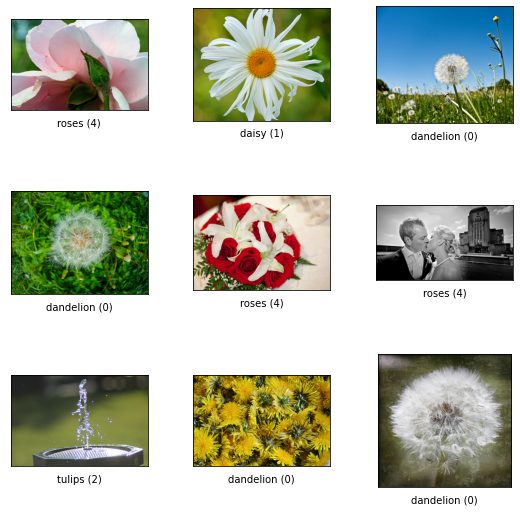

Instructions for updating:
To write TFRecords to disk, use `tf.io.TFRecordWriter`. To save and load the contents of a dataset, use `tf.data.experimental.save` and `tf.data.experimental.load`


Instructions for updating:
To write TFRecords to disk, use `tf.io.TFRecordWriter`. To save and load the contents of a dataset, use `tf.data.experimental.save` and `tf.data.experimental.load`


Shard 0 saved after 0s
Shard 1 saved after 1s
Shard 2 saved after 1s
Shard 3 saved after 1s
Shard 4 saved after 2s
Shard 5 saved after 2s
Shard 6 saved after 2s
Shard 7 saved after 3s
Shard 8 saved after 3s
Shard 9 saved after 3s
Directory Stats (tfrecords), at 239 seconds: os.stat_result(st_mode=16877, st_ino=129704, st_dev=2112, st_nlink=2, st_uid=1000, st_gid=1000, st_size=4096, st_atime=1661241288, st_mtime=1661241292, st_ctime=1661241292)


2022-08-23 13:25:02.476699: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 561971200 exceeds 10% of free system memory.
2022-08-23 13:25:02.778961: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 561971200 exceeds 10% of free system memory.
2022-08-23 13:25:03.190946: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 561971200 exceeds 10% of free system memory.
2022-08-23 13:25:03.438932: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 561971200 exceeds 10% of free system memory.
2022-08-23 13:25:03.570037: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 561971200 exceeds 10% of free system memory.


1/1 [==============================] - 42s 42s/step
Shard 0 done after 42s
Shard 0 saved after 42s
1/1 [==============================] - 38s 38s/step
Shard 1 done after 80s
Shard 1 saved after 80s
1/1 [==============================] - 35s 35s/step
Shard 2 done after 115s
Shard 2 saved after 115s
1/1 [==============================] - 36s 36s/step
Shard 3 done after 152s
Shard 3 saved after 152s
1/1 [==============================] - 39s 39s/step
Shard 4 done after 191s
Shard 4 saved after 192s
1/1 [==============================] - 43s 43s/step
Shard 5 done after 235s
Shard 5 saved after 236s
1/1 [==============================] - 37s 37s/step
Shard 6 done after 273s
Shard 6 saved after 273s
1/1 [==============================] - 37s 37s/step
Shard 7 done after 310s
Shard 7 saved after 310s
1/1 [==============================] - 34s 34s/step
Shard 8 done after 344s
Shard 8 saved after 345s
1/1 [==============================] - 37s 37s/step
Shard 9 done after 382s
Shard 9 saved after

In [47]:
target_example_count = 2000
target_shard_count = 10
target_batch_size = min(int(target_example_count/target_shard_count), 50)

# NOTE: Uncomment the below on a fresh machine
# NOTE: MUST comment this whenever the target-config is revised
# Once downloaded and saved, comment it back
# Once downloaded and save, we can reuse the same for all the future runs
#download_and_save_flowers_dataset(example_count=target_example_count)

# NOTE: Uncomment the below for (re)clculation of embeddings
# NOTE: MUST uncomment this whenever any of the above are uncommented
# Once embeddings are calculated, comment it back
# Once embeddings are calculated for a selected model, we can reuse the same for all the future runs 
#calculate_and_save_embeddings_flowers_dataset(shard_count=target_shard_count, batch_size=target_batch_size)

In [48]:
index, embeds, id_map, name_map = build_search_index()

Shapes: DataFrame = (2000, 2), Embeddings = (2000, 2304)
Map Sizes: id_map = 2000, name_map = 2000



Query Image:  image_0070_dandelion


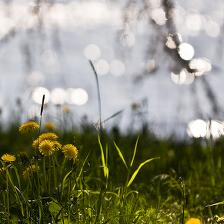


Query Resut Images: 



Query Image:  image_0310_daisy


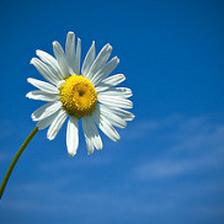


Query Resut Images: 



Query Image:  image_0670_sunflowers


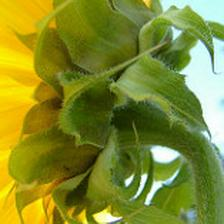


Query Resut Images: 



Query Image:  image_1070_roses


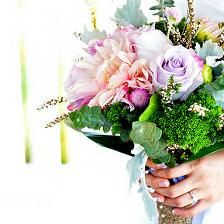


Query Resut Images: 



Query Image:  image_1310_roses


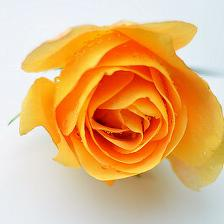


Query Resut Images: 



Query Image:  image_1670_dandelion


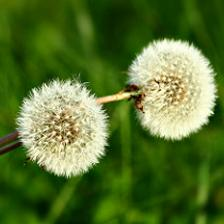


Query Resut Images: 



Query Image:  image_0781_sunflowers


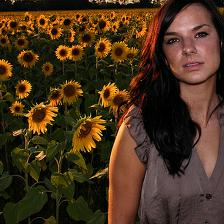


Query Resut Images: 



Query Image:  image_1431_dandelion


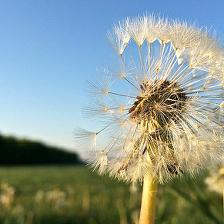


Query Resut Images: 



Query Image:  image_0762_tulips


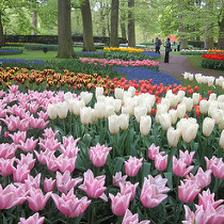


Query Resut Images: 



Query Image:  image_1552_daisy


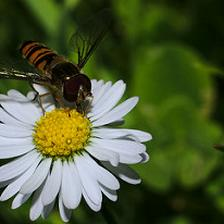


Query Resut Images: 



Query Image:  image_0493_sunflowers


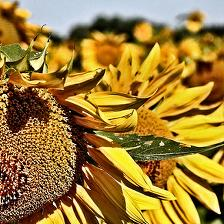


Query Resut Images: 



Query Image:  image_1613_dandelion


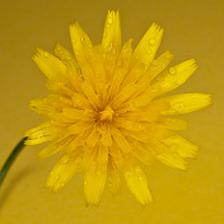


Query Resut Images: 



Query Image:  image_0734_dandelion


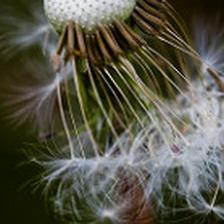


Query Resut Images: 



Query Image:  image_1664_sunflowers


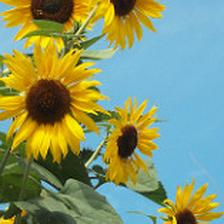


Query Resut Images: 



Query Image:  image_0346_tulips


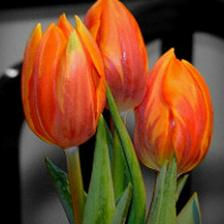


Query Resut Images: 



Query Image:  image_1766_daisy


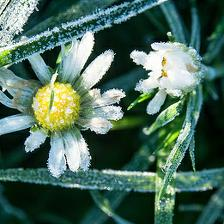


Query Resut Images: 



Query Image:  image_1247_dandelion


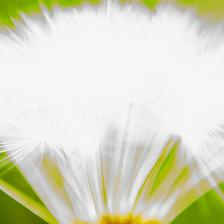


Query Resut Images: 



Query Image:  image_1118_sunflowers


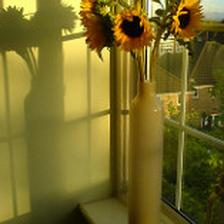


Query Resut Images: 



Query Image:  image_0579_sunflowers


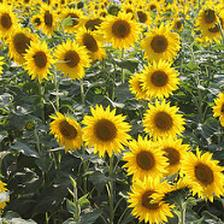


Query Resut Images: 



Query Image:  image_1709_tulips


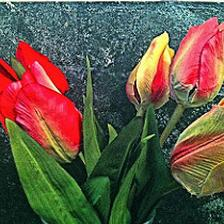


Query Resut Images: 


In [49]:
match_image_ids = [
     7,   31,   67,  107,  131,
   167,  278,  343,  476,  555,
   649,  761,  873,  966, 1234,
  1376, 1524, 1711, 1857, 1970
]

for image_id in match_image_ids:
  search_and_display(index, embeds, id_map, image_id)

In [50]:
# Compute Total Run Time
run_time_seconds = int(pkg_time.time() - run_start_time)
print("Total Run Time: {} seconds".format(run_time_seconds))

Total Run Time: 634 seconds
